In [7]:
import pandas as pd
df = pd.read_csv("nfl_elo.csv")
df = df[df["season"] >= 1994].reset_index(drop=True)
print(df.head())
print(df["season"].min(), df["season"].max())
df=df[df["score1"]!=df["score2"]].reset_index(drop=True)
team_abbr = sorted(df["team2"].unique().tolist())
df["prev_winstreak1"]=0
df["prev_winstreak2"]=0
for team in team_abbr:
    team_idxs = df.index[(df["team1"] == team) | (df["team2"] == team)].tolist()
    i=0
    prev_season=1994
    current_winstreak=0
    for i,idx in enumerate(team_idxs):
        if df.loc[idx,"season"]!=prev_season:
            current_winstreak=0
            prev_season=df.loc[idx,"season"]
        if df.loc[idx,"team1"] == team:
            if df.loc[idx,"score1"]>df.loc[idx,"score2"]:
                current_winstreak+=1
            else:
                current_winstreak=0
        elif df.loc[idx,"team2"] == team:
            if df.loc[idx,"score2"]>df.loc[idx,"score1"]:
                current_winstreak+=1
            else:
                current_winstreak=0
        if i+1<len(team_idxs):
            if df.loc[team_idxs[i+1],"team1"]==team:
                df.loc[team_idxs[i+1],"prev_winstreak1"]=current_winstreak
            else:
                df.loc[team_idxs[i+1],"prev_winstreak2"]=current_winstreak

         date  season  neutral playoff team1 team2  elo1_pre  elo2_pre  \
0  1994-09-04    1994        0     NaN   LAR   ARI  1411.453  1519.491   
1  1994-09-04    1994        0     NaN    NO    KC  1496.129  1575.760   
2  1994-09-04    1994        0     NaN   WSH   SEA  1461.106  1433.773   
3  1994-09-04    1994        0     NaN   MIA    NE  1502.028  1419.492   
4  1994-09-04    1994        0     NaN   DET   ATL  1503.056  1455.498   

   elo_prob1  elo_prob2  ...  qb2_game_value  qb1_value_post  qb2_value_post  \
0   0.438378   0.561622  ...     -149.415457       47.797567       68.943500   
1   0.478957   0.521043  ...      303.338491       43.739525      134.697021   
2   0.629836   0.370164  ...      148.190844       56.601845       71.583713   
3   0.700417   0.299583  ...      301.581564      160.930719       96.616897   
4   0.656545   0.343455  ...      345.518670       95.837797       98.016302   

   qbelo1_post  qbelo2_post score1  score2  quality  importance  total_rat

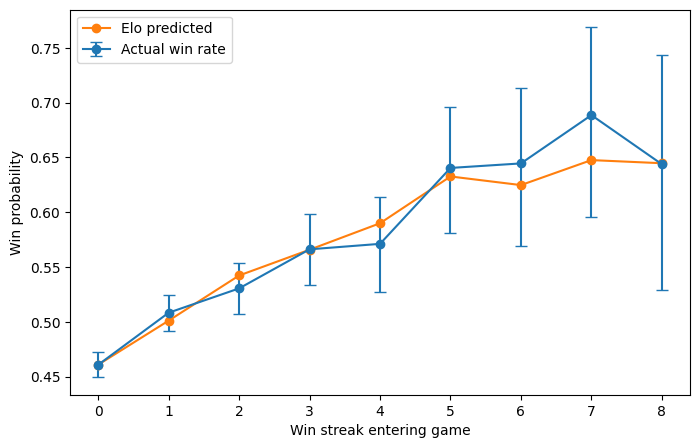

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
r1 = df[["team1", "prev_winstreak1", "elo_prob1", "score1", "score2"]].copy()
r1 = r1.rename(columns={
    "team1": "team",
    "prev_winstreak1": "prev_winstreak",
    "elo_prob1": "elo_prob",
    "score1": "score",
    "score2": "opp_score"
})
r1["outcome"]=0
r1["outcome"] = np.where(r1["score"] > r1["opp_score"], 1, 0)


r2 = df[["team2", "prev_winstreak2", "elo_prob2", "score2", "score1"]].copy()
r2 = r2.rename(columns={
    "team2": "team",
    "prev_winstreak2": "prev_winstreak",
    "elo_prob2": "elo_prob",
    "score2": "score",
    "score1": "opp_score"
})
r2["outcome"] = np.where(r2["score"] > r2["opp_score"], 1, 0)

#treat every game as an individual opportunity for each team within that game. 

long_df = pd.concat([r1, r2], ignore_index=True)

# cap streaks at 8 because the sample size got to 44 when at 9 which was just getting to small to be reliable (error bars way too big). Yes thats an arbitrary cap
long_df = long_df[long_df["prev_winstreak"] <= 8]


grouped = long_df.groupby("prev_winstreak").agg(
    actual_winrate=("outcome", "mean"),
    avg_predicted=("elo_prob", "mean"),
    n_games=("outcome", "count")
).reset_index()
grouped["difference"] = grouped["actual_winrate"] - grouped["avg_predicted"]
import numpy as np
from statsmodels.stats.proportion import proportion_confint

ci_low, ci_high = [], []
grouped["n_wins"]=grouped["actual_winrate"]*grouped["n_games"]
for wins, total in zip(grouped["actual_winrate"] * grouped["n_games"], grouped["n_games"]):
    wins = int(round(wins))
    low, high = proportion_confint(wins, total, alpha=0.05, method="wilson")
    ci_low.append(low)
    ci_high.append(high)


plt.figure(figsize=(8,5))

plt.errorbar(
    grouped["prev_winstreak"],
    grouped["actual_winrate"],
    yerr=[grouped["actual_winrate"] - ci_low, ci_high - grouped["actual_winrate"]],
    fmt="o-",
    capsize=4,
    label="Actual winrate"
)

#Elo Predicted graph
plt.plot(
    grouped["prev_winstreak"],
    grouped["avg_predicted"],
    "o-",
    label="Elo predicted"
)

plt.xlabel("Win streak entering game")
plt.ylabel("Win probability")
plt.legend()
plt.show()
#yes, the methods are kinda elementary, but I'm happy that I learned to use the tools